<a href="https://colab.research.google.com/github/piaosan78/AIFFEL_Quest/blob/master/Exploration_CR5/Chapter_8/GAN_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import time
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 전처리
(train_images, train_labels), (_, _) = cifar10.load_data()
train_images = train_images.astype('float32')

170498071/170498071 [==============================] - 6s 0us/step


In [2]:
train_images = (train_images - 127.5) / 127.5  # 이미지를 [-1, 1]로 정규화

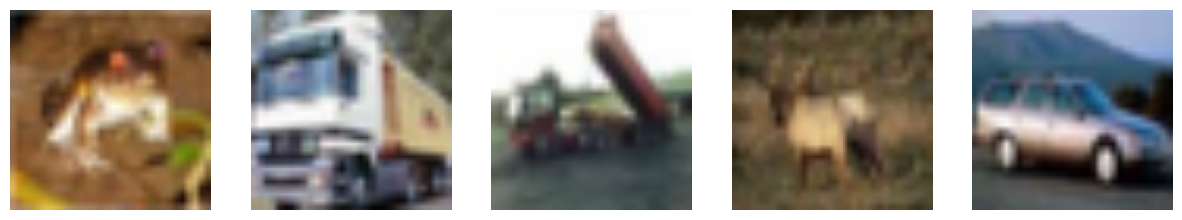

In [3]:
upscaled_size = (96, 96)
upscaled_images = tf.image.resize(train_images, upscaled_size)

# 업스케일링된 이미지 시각화
def plot_images(images, n):
    fig, axes = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        image = (images[i] + 1) / 2.0  # [-1, 1] 범위를 [0, 1]로 변경
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# 처음 5개의 업스케일링된 이미지를 시각화합니다.
plot_images(upscaled_images, 5)

In [4]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
NOISE_DIM = 100

In [16]:
# 2. 생성자와 판별자 모델 생성
def make_generator_model():
    model = Sequential([
        Dense(512, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),

        Dense(8*8*256, use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Reshape((8, 8, 256)),

        Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [17]:
def make_discriminator_model():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1)
    ])
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

In [18]:
# 3. 손실 함수와 최적화 도구 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
# 4. 훈련 루프 정의
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Accuracy
        real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
        fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}, Real Accuracy: {real_accuracy * 100}, Fake Accuracy: {fake_accuracy * 100}')

        # 15 에포크마다 생성된 이미지 저장
        if (epoch + 1) % 15 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    # 마지막 에포크 후 생성된 이미지 저장
    generate_and_save_images(generator, epochs, seed)

In [21]:
# 5. 훈련 실행 및 가짜 이미지 시각화
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [22]:
# 훈련에 사용할 상수 설정
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

In [23]:
# 시각화를 위한 노이즈 벡터 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Epoch 1, Gen Loss: 7.245423793792725, Disc Loss: 0.25061649084091187, Real Accuracy: 95.0, Fake Accuracy: 95.3125
Time for epoch 1 is 16.72157120704651 sec
Epoch 2, Gen Loss: 5.914103031158447, Disc Loss: 0.2500799894332886, Real Accuracy: 92.5, Fake Accuracy: 97.265625
Time for epoch 2 is 9.202219724655151 sec
Epoch 3, Gen Loss: 4.118321418762207, Disc Loss: 0.2155260145664215, Real Accuracy: 97.5, Fake Accuracy: 98.4375
Time for epoch 3 is 9.203668355941772 sec
Epoch 4, Gen Loss: 5.58355712890625, Disc Loss: 0.06366151571273804, Real Accuracy: 97.5, Fake Accuracy: 100.0
Time for epoch 4 is 9.239548206329346 sec
Epoch 5, Gen Loss: 4.546599864959717, Disc Loss: 0.12969408929347992, Real Accuracy: 96.25, Fake Accuracy: 100.0
Time for epoch 5 is 9.219035387039185 sec
Epoch 6, Gen Loss: 4.854048728942871, Disc Loss: 0.09900272637605667, Real Accuracy: 96.25, Fake Accuracy: 99.609375
Time for epoch 6 is 9.213597774505615 sec
E

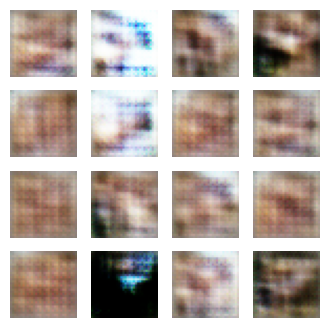

Time for epoch 15 is 9.69647479057312 sec
Epoch 16, Gen Loss: 4.3503737449646, Disc Loss: 0.3545721173286438, Real Accuracy: 90.0, Fake Accuracy: 98.4375
Time for epoch 16 is 9.226994752883911 sec
Epoch 17, Gen Loss: 3.023393392562866, Disc Loss: 0.30561813712120056, Real Accuracy: 90.0, Fake Accuracy: 98.046875
Time for epoch 17 is 9.224990367889404 sec
Epoch 18, Gen Loss: 3.7763094902038574, Disc Loss: 0.2600697875022888, Real Accuracy: 93.75, Fake Accuracy: 97.265625
Time for epoch 18 is 9.223714113235474 sec
Epoch 19, Gen Loss: 4.792092800140381, Disc Loss: 0.25114530324935913, Real Accuracy: 90.0, Fake Accuracy: 97.65625
Time for epoch 19 is 9.233550310134888 sec
Epoch 20, Gen Loss: 4.9142279624938965, Disc Loss: 0.23148806393146515, Real Accuracy: 95.0, Fake Accuracy: 98.4375
Time for epoch 20 is 9.224443435668945 sec
Epoch 21, Gen Loss: 4.860804080963135, Disc Loss: 0.2751089632511139, Real Accuracy: 92.5, Fake Accuracy: 97.265625
Time for epoch 21 is 9.225672006607056 sec
Epoch

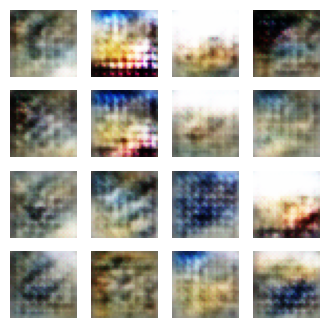

Time for epoch 30 is 9.627650022506714 sec
Epoch 31, Gen Loss: 6.238654613494873, Disc Loss: 0.10616973042488098, Real Accuracy: 96.25, Fake Accuracy: 98.828125
Time for epoch 31 is 9.230477333068848 sec
Epoch 32, Gen Loss: 4.5736284255981445, Disc Loss: 0.3312050700187683, Real Accuracy: 91.25, Fake Accuracy: 94.140625
Time for epoch 32 is 9.223933696746826 sec
Epoch 33, Gen Loss: 4.232156753540039, Disc Loss: 0.2994537055492401, Real Accuracy: 91.25, Fake Accuracy: 98.4375
Time for epoch 33 is 9.232529163360596 sec
Epoch 34, Gen Loss: 4.386005401611328, Disc Loss: 0.40302273631095886, Real Accuracy: 88.75, Fake Accuracy: 96.875
Time for epoch 34 is 9.237887382507324 sec
Epoch 35, Gen Loss: 5.101428985595703, Disc Loss: 0.14491918683052063, Real Accuracy: 97.5, Fake Accuracy: 97.65625
Time for epoch 35 is 9.21413779258728 sec
Epoch 36, Gen Loss: 4.7171406745910645, Disc Loss: 0.17852742969989777, Real Accuracy: 96.25, Fake Accuracy: 97.65625
Time for epoch 36 is 9.22275424003601 sec
E

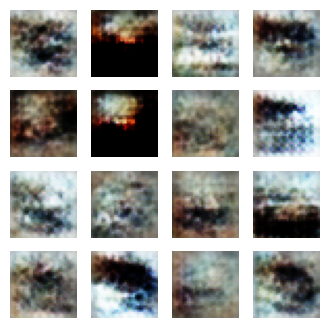

Time for epoch 45 is 9.869572162628174 sec
Epoch 46, Gen Loss: 2.989872455596924, Disc Loss: 0.48830288648605347, Real Accuracy: 86.25, Fake Accuracy: 96.09375
Time for epoch 46 is 9.234352350234985 sec
Epoch 47, Gen Loss: 4.148365020751953, Disc Loss: 0.19176286458969116, Real Accuracy: 95.0, Fake Accuracy: 99.21875
Time for epoch 47 is 9.21493148803711 sec
Epoch 48, Gen Loss: 3.910008668899536, Disc Loss: 0.40236252546310425, Real Accuracy: 86.25, Fake Accuracy: 98.046875
Time for epoch 48 is 9.223145723342896 sec
Epoch 49, Gen Loss: 2.635698080062866, Disc Loss: 0.6073572635650635, Real Accuracy: 77.5, Fake Accuracy: 96.875
Time for epoch 49 is 9.2264564037323 sec
Epoch 50, Gen Loss: 2.927950382232666, Disc Loss: 0.3513646721839905, Real Accuracy: 92.5, Fake Accuracy: 94.53125
Time for epoch 50 is 9.216129064559937 sec
Epoch 51, Gen Loss: 2.685199022293091, Disc Loss: 0.5258123874664307, Real Accuracy: 85.0, Fake Accuracy: 92.578125
Time for epoch 51 is 9.232791662216187 sec
Epoch 5

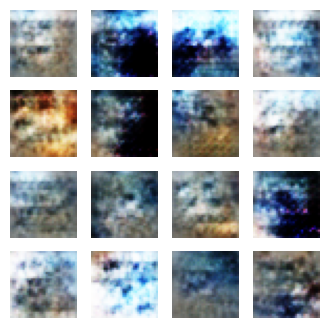

Time for epoch 60 is 9.681503057479858 sec
Epoch 61, Gen Loss: 2.358931541442871, Disc Loss: 0.7909895181655884, Real Accuracy: 78.75, Fake Accuracy: 88.28125
Time for epoch 61 is 9.251179933547974 sec
Epoch 62, Gen Loss: 3.490983486175537, Disc Loss: 0.41999226808547974, Real Accuracy: 87.5, Fake Accuracy: 94.921875
Time for epoch 62 is 9.22603440284729 sec
Epoch 63, Gen Loss: 4.161789894104004, Disc Loss: 0.3045539855957031, Real Accuracy: 93.75, Fake Accuracy: 97.65625
Time for epoch 63 is 9.232001066207886 sec
Epoch 64, Gen Loss: 3.4174346923828125, Disc Loss: 0.37370961904525757, Real Accuracy: 92.5, Fake Accuracy: 92.578125
Time for epoch 64 is 9.233889818191528 sec
Epoch 65, Gen Loss: 3.325042247772217, Disc Loss: 0.28319990634918213, Real Accuracy: 92.5, Fake Accuracy: 97.265625
Time for epoch 65 is 9.237568378448486 sec
Epoch 66, Gen Loss: 3.1441285610198975, Disc Loss: 0.35776376724243164, Real Accuracy: 91.25, Fake Accuracy: 94.53125
Time for epoch 66 is 9.226499557495117 se

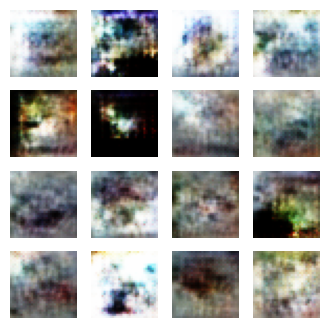

Time for epoch 75 is 9.649863481521606 sec
Epoch 76, Gen Loss: 3.7237017154693604, Disc Loss: 0.48382025957107544, Real Accuracy: 83.75, Fake Accuracy: 94.53125
Time for epoch 76 is 9.244861602783203 sec
Epoch 77, Gen Loss: 3.0181989669799805, Disc Loss: 0.4719846248626709, Real Accuracy: 86.25, Fake Accuracy: 93.359375
Time for epoch 77 is 9.236774206161499 sec
Epoch 78, Gen Loss: 3.904677629470825, Disc Loss: 0.5695021152496338, Real Accuracy: 82.5, Fake Accuracy: 94.921875
Time for epoch 78 is 9.233973741531372 sec
Epoch 79, Gen Loss: 3.8306565284729004, Disc Loss: 0.45496517419815063, Real Accuracy: 86.25, Fake Accuracy: 94.53125
Time for epoch 79 is 9.232687711715698 sec
Epoch 80, Gen Loss: 3.2544736862182617, Disc Loss: 0.4922436773777008, Real Accuracy: 80.0, Fake Accuracy: 94.921875
Time for epoch 80 is 9.22921895980835 sec
Epoch 81, Gen Loss: 3.628326654434204, Disc Loss: 0.3801151514053345, Real Accuracy: 90.0, Fake Accuracy: 95.3125
Time for epoch 81 is 9.225096464157104 sec

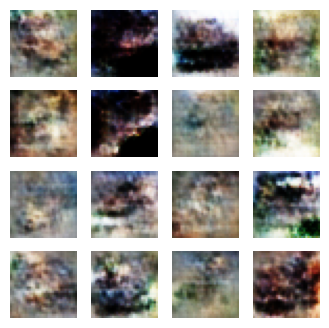

Time for epoch 90 is 9.661419868469238 sec
Epoch 91, Gen Loss: 3.200845718383789, Disc Loss: 0.3344983160495758, Real Accuracy: 91.25, Fake Accuracy: 97.265625
Time for epoch 91 is 9.25330400466919 sec
Epoch 92, Gen Loss: 2.8380463123321533, Disc Loss: 0.4620857834815979, Real Accuracy: 85.0, Fake Accuracy: 94.140625
Time for epoch 92 is 9.22096300125122 sec
Epoch 93, Gen Loss: 3.0680625438690186, Disc Loss: 0.3899191617965698, Real Accuracy: 91.25, Fake Accuracy: 92.578125
Time for epoch 93 is 9.219197511672974 sec
Epoch 94, Gen Loss: 2.955059051513672, Disc Loss: 0.5052574872970581, Real Accuracy: 86.25, Fake Accuracy: 94.140625
Time for epoch 94 is 9.213945627212524 sec
Epoch 95, Gen Loss: 3.699887990951538, Disc Loss: 0.4340704679489136, Real Accuracy: 87.5, Fake Accuracy: 96.09375
Time for epoch 95 is 9.222440481185913 sec
Epoch 96, Gen Loss: 3.5519182682037354, Disc Loss: 0.5504688620567322, Real Accuracy: 76.25, Fake Accuracy: 97.265625
Time for epoch 96 is 9.225003957748413 sec

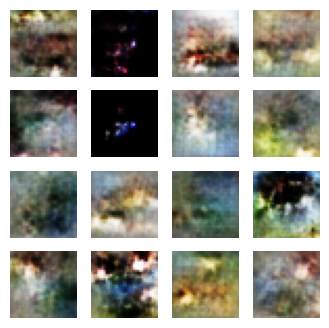

In [24]:
# GAN 훈련
%time
train(train_dataset, EPOCHS)

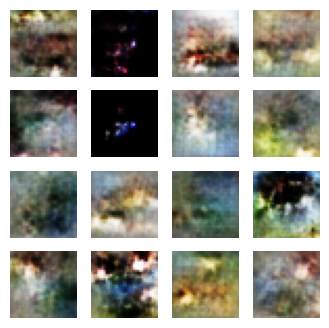

In [25]:
# 마지막 훈련 에폭 후 생성된 이미지 시각화
generate_and_save_images(generator, EPOCHS, seed)

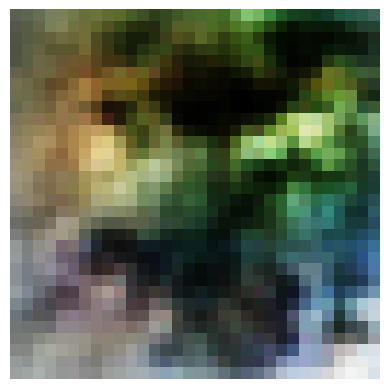

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# 랜덤 노이즈 생성
noise = tf.random.normal([1, 100])

# 생성자를 사용하여 이미지 생성
generated_image = generator(noise, training=False)

# 생성된 이미지 시각화
plt.imshow((generated_image[0, :, :, :] + 1) / 2.0)  # [-1, 1] 범위를 [0, 1]로 변경
plt.axis('off')
plt.show()
